# Image Classifier Prototype

In [44]:
from fashion_image_classifier.feature_extraction import FeatureExtractor
from glob import glob
import numpy as np
from sklearn.metrics import accuracy_score, log_loss
from tqdm import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA, PCA
from sklearn.manifold import TSNE
import seaborn as sns
from bayes_opt import BayesianOptimization

## Loading Images

In [2]:
not_worn_paths = glob("../workdir/training_images/not-worn/image_*.png")
worn_paths = glob("../workdir/training_images/worn/image_*.png")
print(f"Negative Training Samples: {len(not_worn_paths)}")
print(f"Positive Training Samples: {len(worn_paths)}")

Negative Training Samples: 64
Positive Training Samples: 208


In [3]:
extractor = FeatureExtractor()
X_negative = extractor.extract_features(images_paths=not_worn_paths)
y_negative = np.array([0] * X_negative.shape[0])
X_positive = extractor.extract_features(images_paths=worn_paths)
y_positive = np.array([1] * X_positive.shape[0])

In [4]:
X = np.vstack([X_negative, X_positive])
y = np.hstack([y_negative, y_positive])

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (272, 196608)
Shape of y: (272,)


## Step 0: Cluster Visualization

100%|██████████| 10/10 [03:41<00:00, 22.14s/it]


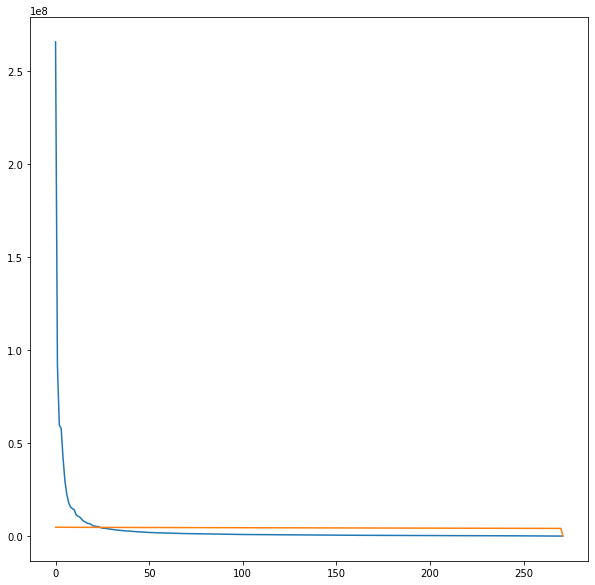

In [37]:
def find_pcs(data, permutations=30):
    noise_variance_matrix = []
    for _ in tqdm(range(permutations), total=permutations):
        noise = data.flatten()
        np.random.shuffle(noise)
        noise = noise.reshape(data.shape)
        noise_variance_vector = PCA().fit(noise).explained_variance_
        noise_variance_matrix.append(noise_variance_vector)
        
    actual_variance_vector = PCA().fit(data).explained_variance_
    mean_noise_variance_vector = np.mean(np.vstack(noise_variance_matrix), axis=0)
    
    return actual_variance_vector, mean_noise_variance_vector

actual_var, noise_var = find_pcs(X, permutations=10)

fig, ax = plt.subplots(figsize=(10, 10))

ax = plt.plot(actual_var)
ax = plt.plot(noise_var)

plt.show()

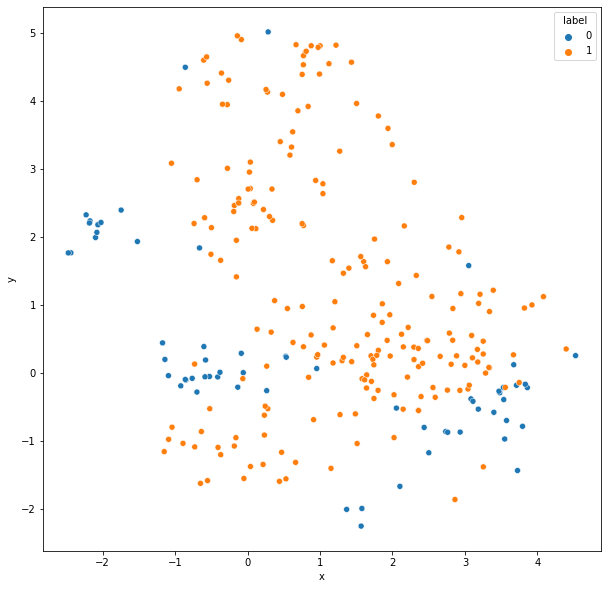

In [36]:
feature_space = PCA(n_components=25).fit_transform(X)

feature_projection = TSNE(n_components=2, perplexity=X.shape[0]/2, n_iter=1000).fit_transform(feature_space)
feature_projection = pd.DataFrame({"x": feature_projection[:, 0], "y": feature_projection[:, 1], "label": y})

fig, ax = plt.subplots(figsize=(10, 10))

_ = sns.scatterplot(x="x", y='y', data=feature_projection, hue="label", ax=ax)

## Step 1: Naive Classifier

In [5]:
y_mean = np.mean(y)
y_naive = [y_mean] * y.shape[0]

print(f"Naive Accuracy: {accuracy_score(y, np.round(y_naive))}")
print(f"Naive Log-Loss: {log_loss(y, y_naive)}")

Naive Accuracy: 0.7647058823529411
Naive Log-Loss: 0.5455945739691842


## Step 2: Simple (no HPT) Logit Classifier

In [6]:
splitter = RepeatedStratifiedKFold(n_splits=10, n_repeats=5)

metric_results = []

for train_index, test_index in tqdm(splitter.split(X, y), total=50, desc="Repeated Fitting"):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    logit = SGDClassifier(loss="log", max_iter=5_000, random_state=42069)
    logit.fit(X_train, y_train)
    y_hat = logit.predict_proba(X_train)[:, 1]
    y_hat_test = logit.predict_proba(X_test)[:, 1]
    
    metrics = {
        "train_accuracy": accuracy_score(y_train, np.round(y_hat)),
        "test_accuracy": accuracy_score(y_test, np.round(y_hat_test)),
        "train_loss": log_loss(y_train, y_hat),
        "test_loss": log_loss(y_test, y_hat_test),
    }
    metric_results.append(metrics)

Repeated Fitting: 100%|██████████| 50/50 [02:55<00:00,  3.51s/it]


### Evaluation

,train_accuracy,test_accuracy,train_loss,test_loss
count,50.000000,50.000000,50.000000,5.000000e+01
mean,0.939542,0.870661,2.088170,4.467242e+00
std,0.067397,0.080268,2.327827,2.772352e+00
min,0.624490,0.629630,0.283108,9.992007e-16
25%,0.934694,0.851852,0.704886,2.558457e+00
50%,0.965239,0.888889,1.200620,3.837731e+00
75%,0.979592,0.925926,2.255645,5.116915e+00
max,0.991803,1.000000,12.969663,1.279214e+01


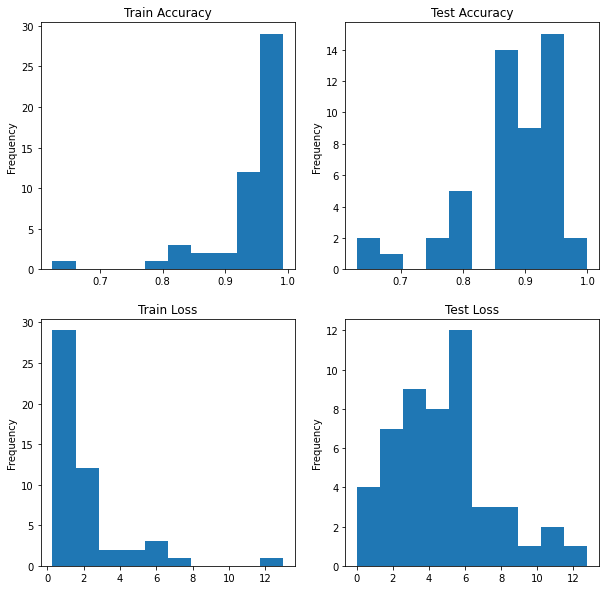

In [14]:
metrics = pd.DataFrame(metric_results)

display(metrics.describe())


fig, ax = plt.subplots(2, 2, figsize=(10, 10))
_ = metrics.train_accuracy.plot(kind="hist", ax=ax[0][0], title="Train Accuracy")
_ = metrics.test_accuracy.plot(kind="hist", ax=ax[0][1], title="Test Accuracy")
_ = metrics.train_loss.plot(kind="hist", ax=ax[1][0], title="Train Loss")
_ = metrics.test_loss.plot(kind="hist", ax=ax[1][1], title="Test Loss")

## Step 2b: Complex Logit Classifier

In [45]:
logit_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", KernelPCA()),
    ("classifier", SGDClassifier(loss='log', max_iter=5_000, random_state=42069))
])

param_bounds = {
    "use_scaler": (0, 1),
    "use_pca": (0, 1),
    "classifier_alpha": (1e-4, 1)
}

def logit_fit_function(use_scaler, use_pca, classifier_alpha):
    splitter = RepeatedStratifiedKFold(n_splits=10, n_repeats=2)
    
    pipeline = logit_pipeline = Pipeline([
        ("scaler", StandardScaler() if use_pca >= 0.5 else "passthrough"),
        ("pca", KernelPCA() if use_pca >= 0.5 else "passthrough"),
        ("classifier", SGDClassifier(loss='log', max_iter=5_000, random_state=42069, alpha=classifier_alpha))
    ])
    
    for train_index, val_index in splitter.split(X, y):
        X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]
        
        _ = pipeline.fit(X_train, y_train)
        y_hat = pipeline.predict_proba(X_val)
        
        val_loss = -log_loss(y_val, y_hat)
        
    return val_loss


optimizer = BayesianOptimization(
    f=logit_fit_function,
    pbounds=param_bounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(
    init_points=3,
    n_iter=15
)

|   iter    |  target   | classi... |  use_pca  | use_sc... |
-------------------------------------------------------------
|  1        | -3.957    |  0.4171   |  0.7203   |  0.000114 |
|  2        | -2.558    |  0.3024   |  0.1468   |  0.09234  |
|  3        | -2.558    |  0.1863   |  0.3456   |  0.3968   |
|  4        | -6.396    |  0.1719   |  0.04687  |  0.347    |
|  5        | -7.879    |  0.5323   |  0.7874   |  0.1749   |
|  6        | -7.675    |  0.5959   |  0.261    |  0.7467   |
|  7        | -5.117    |  0.2276   |  0.1556   |  0.9473   |
|  8        | -1.985    |  0.7263   |  0.7286   |  0.1947   |
|  9        | -3.838    |  0.4703   |  0.4235   |  0.4719   |
|  10       | -0.4344   |  0.9555   |  0.6641   |  0.4707   |
|  11       | -4.614    |  0.4888   |  0.8412   |  0.9791   |
|  12       | -4.784    |  0.3225   |  0.7635   |  0.857    |
|  13       | -2.699    |  0.855    |  0.7194   |  0.912    |
|  14       | -3.715    |  0.6771   |  0.5479   |  0.3832   |
|  15   

## Step 3: SVC

## Step 4: Neural Network